# Assignment 4 - Generative Adversarial Networks (GANs)

**DS552 - Generative AI**

---

# Part 1: Theory Questions

## Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.

The minimax loss function formulates GAN training as a two-player zero-sum game and is the mathematical foundation that drives competitive, adversarial learning.

### 1. Mathematical Formulation
The value function is:

**min_G max_D V(D, G) = E_{x~p_data}[log D(x)] + E_{z~p_z}[log(1 - D(G(z)))]**

where x is real data, z is noise, G(z) is the generated sample, and D(·) outputs a probability (real vs. fake).

### 2. Interpretation of Min and Max
- **Discriminator (maximize):** D aims to maximize V(D,G). It wants to assign high probability to real data D(x) ≈ 1 and low probability to fakes D(G(z)) ≈ 0, so log D(x) and log(1 - D(G(z))) are both large.
- **Generator (minimize):** G aims to minimize V(D,G). The only term under G's control is E_z[log(1 - D(G(z)))]. Minimizing it is equivalent to making D(G(z)) large — i.e., making generated samples look real to D.

### 3. How It Ensures Competitive Training
- The discriminator is trained to separate real from fake; the generator is trained to fool the discriminator. Neither can succeed without the other improving.
- At the Nash equilibrium, D cannot distinguish real from fake (D(x) = D(G(z)) = 1/2), and G matches the data distribution (p_g = p_data).
- In practice, training alternates: update D to increase V, then update G to decrease V. This creates a dynamic where both networks are constantly pushed to improve, leading to better generators and more discriminative critics.

### 4. Connection to Binary Cross-Entropy
In implementation, the discriminator is trained with binary cross-entropy: real labels 1, fake labels 0. The generator is trained to maximize D(G(z)) (or equivalently minimize log(1 - D(G(z)))), which matches the minimax objective.

---

## Q2: What is mode collapse? Why can mode collapse occur during GAN training? How can it be mitigated?

### 1. What is Mode Collapse?
Mode collapse occurs when the generator produces only a limited subset of the data distribution — often a few distinct outputs or even a single repeated pattern — instead of capturing the full diversity (all "modes") of the target distribution. The generator may find one or a few samples that reliably fool the discriminator and then keep producing those, ignoring other modes.

### 2. Why Can Mode Collapse Occur?
- **Generator's incentive:** The generator is only rewarded for fooling the discriminator. If a small set of outputs consistently gets high D(G(z)), the generator can reduce its loss by concentrating probability mass on those outputs, rather than exploring the full distribution.
- **Discriminator feedback:** If the discriminator does not penalize lack of diversity (it only checks "real vs. fake" per sample), the generator is not explicitly encouraged to cover all modes.
- **Optimization dynamics:** The minimax game can have equilibria where the generator collapses to a few modes while the discriminator remains good at rejecting other fakes but is fooled by the collapsed set. Such local equilibria can be stable and hard to escape.
- **Capacity and gradient issues:** When the discriminator becomes very strong, gradients to the generator can vanish or become noisy, making it hard for the generator to learn a diverse mapping; it may then settle for a narrow, high-reward subset.

### 3. How Can It Be Mitigated?
- **Architectural and training tricks:** Use batch normalization, avoid full collapse of the discriminator (e.g., don't train D too many steps per G step), and use techniques such as minibatch discrimination so the discriminator can use statistics over a batch to detect lack of diversity.
- **Alternative objectives:** Wasserstein GAN (WGAN) and other loss functions (e.g., non-saturating generator loss) can provide more informative gradients and more stable training, often reducing mode collapse.
- **Regularization and diversity:** Add terms or procedures that encourage diversity (e.g., entropy regularization, unrolled GANs, or diversity-promoting losses).
- **Training balance:** Keep the discriminator and generator in a healthy balance so that the generator receives useful gradients across many modes rather than collapsing to a few.

---

## Q3: Explain the role of the discriminator in adversarial training.

The discriminator is the "adversary" that provides the learning signal for the generator and defines what "realistic" means during training.

### 1. Primary Role: Binary Classifier
The discriminator is trained to classify inputs as *real* (from the data distribution p_data) or *fake* (from the generator distribution p_g). It outputs a score or probability that the input is real. This binary decision is the core of adversarial training.

### 2. Providing Learning Signal to the Generator
The generator has no direct access to the data. It learns only through the discriminator's response:
- When D(G(z)) is low, the generator receives gradients that push it to produce samples that D is more likely to classify as real.
- The discriminator therefore acts as a learned, adaptive loss: it defines which generated samples are good (high D(G(z))) and which are bad (low D(G(z))).

### 3. Driving the Adversarial Game
- The discriminator tries to maximize accuracy (or the value function V(D,G)); the generator tries to minimize the discriminator's ability to tell real from fake.
- As the discriminator improves, it forces the generator to produce more realistic and diverse samples. As the generator improves, it forces the discriminator to become more discriminative. This feedback loop is what makes training "adversarial."

### 4. Balancing Act
If the discriminator is too strong, it can reject almost all fakes and gradients to the generator can vanish. If it is too weak, the generator receives little useful signal. Successful adversarial training requires keeping the discriminator and generator in a rough balance so that the discriminator remains a useful critic without dominating the game.

### 5. Summary
The discriminator's role is to (1) distinguish real from generated data, (2) supply a differentiable signal so the generator can improve, and (3) participate in the minimax game that pushes both networks toward an equilibrium where the generator's distribution matches the data.

---

## Q4: How do metrics like IS and FID evaluate GAN performance?

Inception Score (IS) and Fréchet Inception Distance (FID) are widely used to evaluate the quality and diversity of generated images without human labeling.

### 1. Inception Score (IS)
- **Setup:** Generated images are passed through a pre-trained Inception network. The conditional label distribution p(y|x) (over Inception classes) is computed for each generated image x.
- **Formula:** IS = exp(E_{x~p_g}[KL(p(y|x) || p(y))]), where p(y) = E_{x~p_g}[p(y|x)] is the marginal class distribution.
- **Interpretation:**
  - **Quality:** If p(y|x) is peaked (high confidence), the model assigns each image to a clear class → image is likely meaningful and recognizable.
  - **Diversity:** If p(y) is uniform (many classes used), the model generates a variety of classes → high entropy of p(y).
- Higher IS indicates better quality and diversity. IS does not compare directly to real data statistics.

### 2. Fréchet Inception Distance (FID)
- **Setup:** Real and generated images are passed through the same Inception network. The mean and covariance of the resulting feature vectors are computed for the real distribution (m_r, C_r) and the generated distribution (m_g, C_g).
- **Formula:** FID = ||m_r - m_g||² + Tr(C_r + C_g - 2(C_r · C_g)^(1/2))
- **Interpretation:** FID measures how close the distribution of Inception features of generated images is to that of real images. Lower FID means the generated distribution is closer to the real one in feature space, reflecting better quality and diversity.

### 3. Comparison

| Aspect | IS | FID |
|--------|-----|-----|
| Reference | No real data needed | Uses real data statistics |
| Measures | Quality + diversity (classes) | Distance to real distribution |
| Better when | Higher | Lower |
| Sensitivity | Limited | Often more correlated with human judgment |

Both metrics rely on Inception features as a proxy for semantic content. FID is generally preferred when comparing GANs to real data because it explicitly compares the generated and real distributions in a principled way.

---

# Part 2: Coding Assignment

**Note:** The original assignment code was provided in TensorFlow. Below, we re-implement everything in **PyTorch** for consistency with our course environment.

We implement:
1. A GAN on **MNIST** (28×28×1) — base implementation
2. A GAN on **CIFAR-10** (32×32×3) — with additional convolutional layers and updated dimensions
3. Image saving every 10 epochs for both

### Tuning improvements applied (DCGAN best practices):
- **Weight initialization**: `N(0, 0.02)` for Conv/Linear, `N(1, 0.02)` for BatchNorm
- **Adam betas**: `(0.5, 0.999)` instead of default `(0.9, 0.999)` — reduces momentum for more stable GAN training
- **Learning rate**: `2e-4` (standard DCGAN)
- **Label smoothing**: real labels = 0.9 to prevent discriminator overconfidence
- **BatchNorm in discriminator** (except first layer) for training stability

---

# Section A: GAN on MNIST Dataset

## A.1 Imports and setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ----- DCGAN-style weight initialisation (critical for GAN stability) -----
def weights_init(m):
    """Apply DCGAN weight initialisation: Conv/ConvTranspose ~ N(0, 0.02), BatchNorm ~ N(1, 0.02)."""
    classname = m.__class__.__name__
    if 'Conv' in classname and hasattr(m, 'weight'):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif 'Linear' in classname and hasattr(m, 'weight'):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# ----- Hyperparameters -----
NOISE_DIM = 100
LR = 2e-4                # DCGAN standard learning rate
BETAS = (0.5, 0.999)     # DCGAN standard Adam betas
REAL_LABEL_VAL = 0.9      # Label smoothing for real samples

Using device: cpu


/home/piyush/miniconda3/envs/rl/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## A.2 Data preparation — MNIST

In [2]:
BATCH_SIZE_MNIST = 256

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

mnist_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=mnist_transform
)
mnist_loader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE_MNIST, shuffle=True, num_workers=2, drop_last=True)

print(f'MNIST training set: {len(mnist_dataset)} images')
print('Image shape: 1x28x28')

MNIST training set: 60000 images
Image shape: 1x28x28


## A.3 Generator model (MNIST — 28×28×1)

Noise (100) → Linear → 7×7×256 → ConvTranspose2d blocks → 28×28×1

In [3]:
class MNISTGenerator(nn.Module):
    def __init__(self):
        super(MNISTGenerator, self).__init__()
        self.project = nn.Sequential(
            nn.Linear(NOISE_DIM, 7 * 7 * 256, bias=False),
            nn.BatchNorm1d(7 * 7 * 256),
            nn.ReLU(True),
        )
        self.conv_blocks = nn.Sequential(
            # Block 1: 7x7 -> 7x7 (refine features)
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Block 2: 7x7 -> 14x14
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 3: 14x14 -> 28x28, 1 channel output
            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.project(z)
        x = x.view(-1, 256, 7, 7)
        x = self.conv_blocks(x)
        return x

## A.4 Discriminator model (MNIST — 28×28×1)

Includes BatchNorm on hidden conv layers (not the first) for stability.

In [4]:
class MNISTDiscriminator(nn.Module):
    def __init__(self):
        super(MNISTDiscriminator, self).__init__()
        self.model = nn.Sequential(
            # 28x28 -> 14x14  (no BatchNorm on first layer per DCGAN)
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            # 14x14 -> 7x7
            nn.Conv2d(64, 128, 5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # Flatten -> 1
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
        )

    def forward(self, x):
        return self.model(x)

## A.5 Loss functions, optimizers, and helpers

In [5]:
mnist_gen = MNISTGenerator().to(device)
mnist_disc = MNISTDiscriminator().to(device)

# Apply DCGAN weight initialisation
mnist_gen.apply(weights_init)
mnist_disc.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()

# DCGAN-tuned Adam: lr=2e-4, betas=(0.5, 0.999)
mnist_gen_opt = optim.Adam(mnist_gen.parameters(), lr=LR, betas=BETAS)
mnist_disc_opt = optim.Adam(mnist_disc.parameters(), lr=LR, betas=BETAS)

print(mnist_gen)
print()
print(mnist_disc)

MNISTGenerator(
  (project): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

MNISTDiscriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_sl

In [6]:
MNIST_OUTPUT_DIR = 'generated_images_mnist'
os.makedirs(MNIST_OUTPUT_DIR, exist_ok=True)

# Fixed noise for consistent visualisation
mnist_fixed_noise = torch.randn(16, NOISE_DIM, device=device)

def save_image_grid(generator, epoch, noise, output_dir, grayscale=False):
    """Generate and save a 4x4 grid of images."""
    generator.eval()
    with torch.no_grad():
        preds = generator(noise).cpu()
    generator.train()

    fig = plt.figure(figsize=(4, 4))
    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i + 1)
        if grayscale:
            img = (preds[i, 0].numpy() + 1) / 2.0
            plt.imshow(np.clip(img, 0, 1), cmap='gray')
        else:
            img = (preds[i].permute(1, 2, 0).numpy() + 1) / 2.0
            plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}', fontsize=12)
    plt.savefig(os.path.join(output_dir, f'epoch_{epoch:04d}.png'), bbox_inches='tight')
    plt.close()

## A.6 Training loop — MNIST

In [7]:
def train_gan(generator, discriminator, gen_opt, disc_opt, dataloader,
              epochs, noise_dim, fixed_noise, output_dir, grayscale=False):
    """Generic GAN training loop with label smoothing."""
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        gen_losses, disc_losses = [], []

        for real_images, _ in dataloader:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Label smoothing: real = 0.9, fake = 0.0
            real_labels = torch.full((batch_size, 1), REAL_LABEL_VAL, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # ---------- Train Discriminator ----------
            noise = torch.randn(batch_size, noise_dim, device=device)
            fake_images = generator(noise)

            real_output = discriminator(real_images)
            fake_output = discriminator(fake_images.detach())

            d_loss = criterion(real_output, real_labels) + criterion(fake_output, fake_labels)

            disc_opt.zero_grad()
            d_loss.backward()
            disc_opt.step()

            # ---------- Train Generator ----------
            noise = torch.randn(batch_size, noise_dim, device=device)
            fake_images = generator(noise)
            fake_output = discriminator(fake_images)

            # Generator wants D to output 1 (real) for fakes
            g_loss = criterion(fake_output, torch.ones(batch_size, 1, device=device))

            gen_opt.zero_grad()
            g_loss.backward()
            gen_opt.step()

            gen_losses.append(g_loss.item())
            disc_losses.append(d_loss.item())

        avg_g = np.mean(gen_losses)
        avg_d = np.mean(disc_losses)
        print(f'Epoch {epoch+1}/{epochs} \u2014 Gen loss: {avg_g:.4f}, Disc loss: {avg_d:.4f}')

        # Save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            save_image_grid(generator, epoch + 1, fixed_noise, output_dir, grayscale)
            print(f'  \u2192 Saved images to {output_dir}/epoch_{epoch+1:04d}.png')

In [8]:
MNIST_EPOCHS = 50

print('Training GAN on MNIST ...')
print('=' * 60)
train_gan(
    generator=mnist_gen,
    discriminator=mnist_disc,
    gen_opt=mnist_gen_opt,
    disc_opt=mnist_disc_opt,
    dataloader=mnist_loader,
    epochs=MNIST_EPOCHS,
    noise_dim=NOISE_DIM,
    fixed_noise=mnist_fixed_noise,
    output_dir=MNIST_OUTPUT_DIR,
    grayscale=True,
)

Training GAN on MNIST ...
Epoch 1/50 — Gen loss: 4.6697, Disc loss: 0.4873
Epoch 2/50 — Gen loss: 2.3899, Disc loss: 0.8113
Epoch 3/50 — Gen loss: 1.5042, Disc loss: 1.1326
Epoch 4/50 — Gen loss: 1.3080, Disc loss: 1.2331
Epoch 5/50 — Gen loss: 1.2193, Disc loss: 1.2628
Epoch 6/50 — Gen loss: 1.1795, Disc loss: 1.2406
Epoch 7/50 — Gen loss: 1.2206, Disc loss: 1.2271
Epoch 8/50 — Gen loss: 1.2101, Disc loss: 1.2250
Epoch 9/50 — Gen loss: 1.2055, Disc loss: 1.2168
Epoch 10/50 — Gen loss: 1.2087, Disc loss: 1.2271
  → Saved images to generated_images_mnist/epoch_0010.png
Epoch 11/50 — Gen loss: 1.2032, Disc loss: 1.2316
Epoch 12/50 — Gen loss: 1.1924, Disc loss: 1.2347
Epoch 13/50 — Gen loss: 1.1857, Disc loss: 1.2217
Epoch 14/50 — Gen loss: 1.2122, Disc loss: 1.2305
Epoch 15/50 — Gen loss: 1.2098, Disc loss: 1.2556
Epoch 16/50 — Gen loss: 1.1925, Disc loss: 1.2296
Epoch 17/50 — Gen loss: 1.1993, Disc loss: 1.2408
Epoch 18/50 — Gen loss: 1.1773, Disc loss: 1.2346
Epoch 19/50 — Gen loss: 1

## A.7 Generate sample images — MNIST

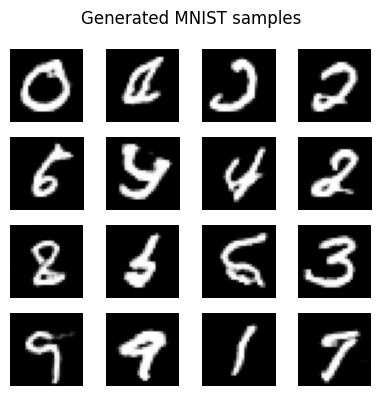

In [9]:
mnist_gen.eval()
sample_noise = torch.randn(16, NOISE_DIM, device=device)
with torch.no_grad():
    generated = mnist_gen(sample_noise).cpu()

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = (generated[i, 0].numpy() + 1) / 2.0
    plt.imshow(np.clip(img, 0, 1), cmap='gray')
    plt.axis('off')
plt.suptitle('Generated MNIST samples')
plt.tight_layout()
plt.show()

---

# Section B: GAN on CIFAR-10 Dataset

We now replace MNIST with **CIFAR-10** (32×32×3) and update the network architectures for the new image dimensions. The generator is also modified to include **additional convolutional layers** to handle the increased complexity of colour images.

## B.1 Data preparation — CIFAR-10

In [10]:
BATCH_SIZE_CIFAR = 128   # Smaller batches work better for harder datasets

cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

cifar_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=cifar_transform
)
cifar_loader = DataLoader(cifar_dataset, batch_size=BATCH_SIZE_CIFAR, shuffle=True, num_workers=2, drop_last=True)

print(f'CIFAR-10 training set: {len(cifar_dataset)} images')
print('Image shape: 3x32x32')

Files already downloaded and verified
CIFAR-10 training set: 50000 images
Image shape: 3x32x32


## B.2 Generator model (CIFAR-10 — 32×32×3, with additional conv layers)

Noise (100) → Linear → 4×4×512 → **four** ConvTranspose2d blocks → 32×32×3.

Compared to the MNIST generator (3 blocks), we add an extra transposed-convolution block to handle the larger spatial size and 3-channel output. Generator uses **ReLU** (DCGAN best practice).

In [11]:
class CIFARGenerator(nn.Module):
    def __init__(self):
        super(CIFARGenerator, self).__init__()
        self.project = nn.Sequential(
            nn.Linear(NOISE_DIM, 4 * 4 * 512, bias=False),
            nn.BatchNorm1d(4 * 4 * 512),
            nn.ReLU(True),
        )
        self.conv_blocks = nn.Sequential(
            # Block 1: 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Block 2: 8x8 -> 16x16 (additional layer)
            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Block 3: 16x16 -> 32x32 (additional layer)
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 4: 32x32 -> 32x32, 3 channels
            nn.ConvTranspose2d(64, 3, 5, stride=1, padding=2, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.project(z)
        x = x.view(-1, 512, 4, 4)
        x = self.conv_blocks(x)
        return x

## B.3 Discriminator model (CIFAR-10 — 32×32×3)

Uses **LeakyReLU** throughout and **BatchNorm** on hidden layers (not the first). Three strided-conv blocks downsample 32×32 to 4×4.

In [12]:
class CIFARDiscriminator(nn.Module):
    def __init__(self):
        super(CIFARDiscriminator, self).__init__()
        self.model = nn.Sequential(
            # 32x32 -> 16x16  (no BatchNorm on first layer per DCGAN)
            nn.Conv2d(3, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16 -> 8x8
            nn.Conv2d(64, 128, 5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # 8x8 -> 4x4
            nn.Conv2d(128, 256, 5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # Flatten -> 1
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
        )

    def forward(self, x):
        return self.model(x)

## B.4 Loss functions and optimizers — CIFAR-10

In [13]:
cifar_gen = CIFARGenerator().to(device)
cifar_disc = CIFARDiscriminator().to(device)

# Apply DCGAN weight initialisation
cifar_gen.apply(weights_init)
cifar_disc.apply(weights_init)

cifar_gen_opt = optim.Adam(cifar_gen.parameters(), lr=LR, betas=BETAS)
cifar_disc_opt = optim.Adam(cifar_disc.parameters(), lr=LR, betas=BETAS)

print(cifar_gen)
print()
print(cifar_disc)

CIFARGenerator(
  (project): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64,

## B.5 Training — CIFAR-10

In [14]:
CIFAR_OUTPUT_DIR = 'generated_images_cifar10'
os.makedirs(CIFAR_OUTPUT_DIR, exist_ok=True)

cifar_fixed_noise = torch.randn(16, NOISE_DIM, device=device)

CIFAR_EPOCHS = 100  # CIFAR-10 is harder, needs more epochs

print('Training GAN on CIFAR-10 ...')
print('=' * 60)
train_gan(
    generator=cifar_gen,
    discriminator=cifar_disc,
    gen_opt=cifar_gen_opt,
    disc_opt=cifar_disc_opt,
    dataloader=cifar_loader,
    epochs=CIFAR_EPOCHS,
    noise_dim=NOISE_DIM,
    fixed_noise=cifar_fixed_noise,
    output_dir=CIFAR_OUTPUT_DIR,
    grayscale=False,
)

Training GAN on CIFAR-10 ...
Epoch 1/100 — Gen loss: 4.1112, Disc loss: 0.8886
Epoch 2/100 — Gen loss: 2.1362, Disc loss: 1.1473
Epoch 3/100 — Gen loss: 2.0212, Disc loss: 1.1574
Epoch 4/100 — Gen loss: 1.8704, Disc loss: 1.1418
Epoch 5/100 — Gen loss: 2.0297, Disc loss: 1.0935
Epoch 6/100 — Gen loss: 1.7334, Disc loss: 1.1640
Epoch 7/100 — Gen loss: 1.6026, Disc loss: 1.1646
Epoch 8/100 — Gen loss: 1.5190, Disc loss: 1.1968
Epoch 9/100 — Gen loss: 1.4433, Disc loss: 1.2332
Epoch 10/100 — Gen loss: 1.4164, Disc loss: 1.2245
  → Saved images to generated_images_cifar10/epoch_0010.png
Epoch 11/100 — Gen loss: 1.3985, Disc loss: 1.2375
Epoch 12/100 — Gen loss: 1.3712, Disc loss: 1.2450
Epoch 13/100 — Gen loss: 1.3275, Disc loss: 1.2444
Epoch 14/100 — Gen loss: 1.3491, Disc loss: 1.2416
Epoch 15/100 — Gen loss: 1.3158, Disc loss: 1.2544
Epoch 16/100 — Gen loss: 1.2821, Disc loss: 1.2531
Epoch 17/100 — Gen loss: 1.2919, Disc loss: 1.2733
Epoch 18/100 — Gen loss: 1.2478, Disc loss: 1.2545
Ep

KeyboardInterrupt: 

## B.6 Generate sample images — CIFAR-10

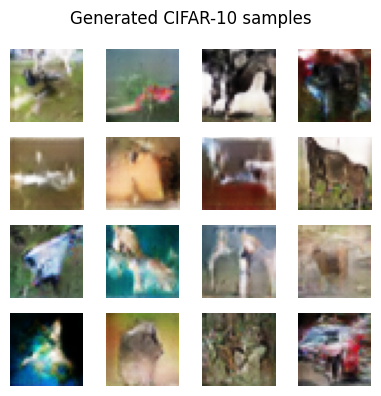

In [15]:
cifar_gen.eval()
sample_noise = torch.randn(16, NOISE_DIM, device=device)
with torch.no_grad():
    generated = cifar_gen(sample_noise).cpu()

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = (generated[i].permute(1, 2, 0).numpy() + 1) / 2.0
    plt.imshow(np.clip(img, 0, 1))
    plt.axis('off')
plt.suptitle('Generated CIFAR-10 samples')
plt.tight_layout()
plt.show()

In [16]:
# Save the trained MNIST GAN models
torch.save(mnist_gen.state_dict(), os.path.join(MNIST_OUTPUT_DIR, 'mnist_gen.pth'))
torch.save(mnist_disc.state_dict(), os.path.join(MNIST_OUTPUT_DIR, 'mnist_disc.pth'))

In [17]:
torch.save(cifar_gen.state_dict(), os.path.join(CIFAR_OUTPUT_DIR, 'cifar_gen.pth'))